# LASSO for Granger Causality

In [324]:
import numpy as np
import pandas as pd
import networkx as nx
from itertools import permutations
import graphviz
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline 

In [325]:
plt.rcParams["figure.figsize"] = [30,10]

In [326]:
data = pd.read_csv('output.csv')

In [327]:
data.head()

,x0,x1,x2,x3,x4
0,-1.662189,-0.100499,-1.350334,-1.189624,-0.043115
1,-0.741303,0.998092,-0.468603,-0.055062,-0.594633
2,0.539278,0.684597,-0.147328,0.184362,-0.728728
3,0.958720,-1.276413,0.059814,0.737735,0.608021
4,0.112009,0.217208,1.193067,-0.400950,0.243941


In [328]:
target = 'x1'
predictors = ['x0',  'x2', 'x3', 'x4']
data[[target] + predictors]

,x1,x0,x2,x3,x4
0,-0.100499,-1.662189,-1.350334,-1.189624,-0.043115
1,0.998092,-0.741303,-0.468603,-0.055062,-0.594633
2,0.684597,0.539278,-0.147328,0.184362,-0.728728
3,-1.276413,0.958720,0.059814,0.737735,0.608021
4,0.217208,0.112009,1.193067,-0.400950,0.243941
...,...,...,...,...,...
1005,0.212048,-0.164189,-0.034687,-0.231840,1.779268
1006,0.249115,2.396835,1.402381,-1.465014,0.073279
1007,0.324912,0.964347,-0.102053,1.043437,0.069016
1008,-1.038647,2.404369,0.790429,1.219525,-0.556328


In [329]:
def transform(data, target, predictors, max_lag):
    new = data[[target] + predictors]
    ts = new.to_numpy()
    transformed = []

    max_lag = 5
    for i in range(ts.shape[0]):
        if i >= max_lag:
            start = i - max_lag 
            target = ts[:,0][i]
            regressors = []
            for ii in range(ts.shape[1]):
                regressors.append(list(ts[:,ii][start:i]))
            transformed.append([target] + list(np.array(regressors).flatten()))

    transformed = np.array(transformed)

    y = transformed[:,0]
    x = transformed[:,1:]
    
    return x, y 

In [330]:
x, y  = transform(data, 'x0', ['x1', 'x2', 'x3', 'x4'], 5)

In [331]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

In [334]:
def findLambda(x, y):
    model_bic = LassoLarsIC(criterion='bic')
    model_bic.fit(x, y)
    return model_bic.alpha_

In [336]:
#model_bic.criterion_

In [337]:
#plt.plot(model_bic.alphas_, model_bic.criterion_)
#plt.axvline(model_bic.alpha_)

In [264]:
def lasso(x, y, l):
    clf = linear_model.Lasso(alpha=l)
    return clf.fit(x, y).coef_

In [363]:
dag = np.zeros((len(data.columns), len(data.columns)))
nodes = list(data.columns)
max_lag=5

for node in range(len(nodes)):
    nodes_copy = nodes.copy()
    nodes_copy.remove(nodes[node])

    # transform
    x, y  = transform(data, nodes[node], nodes_copy, max_lag)

    # get coefficients
    coefs = lasso(x, y, findLambda(x, y))
    
    # place indicator in DAG matrix 
    cnt=0
    for i in list(range(0, max_lag * len(nodes), max_lag)):
        ll = list(range(max_lag))
        ll.remove(node)
        if i==0:
            if coefs[i:i+5].sum() > 0:
                dag[node][node] = 1
        else:
            if coefs[i:i+5].sum() > 0:
                dag[ll[cnt]][node] = 1
            cnt+=1

In [364]:
dag

array([[1., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0.]])

In [365]:
dag

array([[1., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0.]])

In [366]:
# Measure output graph against real graph

In [367]:
G = nx.from_numpy_matrix(dag)

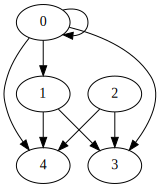

In [368]:
dot = graphviz.Digraph()
for node in G.nodes:
    dot.node(str(node))
for a, b in G.edges:
    dot.edge(str(a), str(b))
    
dot

In [369]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [370]:
true = np.array(pd.read_csv("true_graph.csv"))
true

array([[1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [371]:
print("Precision: " , precision_score(true.flatten(), dag.flatten()))
print("Recal: " , recall_score(true.flatten(), dag.flatten()))
print("F1: " , f1_score(true.flatten(), dag.flatten()))

Precision:  0.18181818181818182
Recal:  0.25
F1:  0.2105263157894737
